# Tennis Solution

In [1]:
from unityagents import UnityEnvironment

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


In [3]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=10)

Episode 1	Average Score: 0.000000	Score: 0.000000	t:   15
Episode 2	Average Score: 0.050000	Score: 0.100000	t:   48
Episode 3	Average Score: 0.033333	Score: 0.000000	t:   14
Episode 4	Average Score: 0.035000	Score: 0.000000	t:   14
Episode 5	Average Score: 0.020000	Score: 0.000000	t:   15
Episode 6	Average Score: 0.026667	Score: 0.000000	t:   14
Episode 7	Average Score: 0.014286	Score: 0.000000	t:   14
Episode 8	Average Score: 0.012500	Score: 0.000000	t:   14
Episode 9	Average Score: 0.011111	Score: 0.000000	t:   14
Episode 10	Average Score: 0.010000	Score: 0.000000	t:   15
Episode 11	Average Score: 0.019091	Score: 0.000000	t:   14
Episode 12	Average Score: 0.018333	Score: 0.000000	t:   14
Episode 13	Average Score: 0.017692	Score: 0.000000	t:   14
Episode 14	Average Score: 0.017143	Score: 0.000000	t:   14
Episode 15	Average Score: 0.016667	Score: 0.000000	t:   15
Episode 16	Average Score: 0.016250	Score: 0.000000	t:   14
Episode 17	Average Score: 0.015882	Score: 0.000000	t:   14
Episod

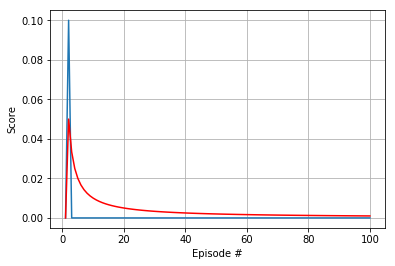

In [4]:
def ddpg(n_episodes=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    mean_scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        states = env.reset(train_mode=True)[brain_name].vector_observations
        agent.reset()
        agent_scores = np.zeros((num_agents))
        t = 0
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, i_episode)
            states = next_states
            agent_scores += np.array(rewards)
            t += 1            
            if all(dones):
                break

        score = np.max(agent_scores)
        scores_deque.append(score)
        scores.append(score)
        mean_scores.append(np.mean(scores_deque))
        print('\rEpisode {}\Max Score: {:.6f}\tScore: {:.6f}\tt: {:4}'.format(i_episode, np.mean(scores_deque), score, t), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=30.0 and i_episode > 150:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break    
    return scores, mean_scores

scores, mean_scores = ddpg(n_episodes=100)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), mean_scores, 'r')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid()
plt.show()

In [5]:
env.close()